# Lab — Knowledge distillation for GNN

<img src='https://raw.githubusercontent.com/netspractice/advanced_gnn/main/lab_knowledge_distillation/LSP_scheme.png' width=900>

source: https://arxiv.org/abs/2003.10477

To enable the knowledge transfer from the teacher GCN to the student, there is a local structure preserving (LSP) module that explicitly accounts for the topological semantics of the teacher. In this module, the local structure information from both the teacher and the student are extracted as distributions, and hence minimizing the distance between these distributions enables topology-aware knowledge transfer from the teacher, yielding a compact yet highperformance student model.

### Prepare dataloader

In the first, step we download protein-protein interaction (PPI) dataset of graphs that come from the human tissues. There are 121 classes, each node can be assigned to more than one class that can be represented as multilabel classification problem. Node features are motif gene sets and immunological signatures.

In [203]:
!pip install dgl-cu111 -f https://data.dgl.ai/wheels/repo.html -q

In [204]:
import dgl
from dgl.data.ppi import LegacyPPIDataset as PPIDataset
import dgl.function as fn
from dgl.nn.functional import edge_softmax

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score

from IPython.display import clear_output

Check the number of graphs

In [205]:
train_dataset = PPIDataset(mode='train')
valid_dataset = PPIDataset(mode='valid')
test_dataset = PPIDataset(mode='test')
len(train_dataset), len(valid_dataset), len(valid_dataset)

(20, 2, 2)

Each entry is graph, node features and node labels 

In [206]:
g, feat, label = train_dataset[0]
g

Graph(num_nodes=1767, num_edges=34085,
      ndata_schemes={'label': Scheme(shape=(121,), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64), 'feat': Scheme(shape=(50,), dtype=torch.float32)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})

In [207]:
g.adj().to_dense()

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [208]:
feat

tensor([[-0.0855, -0.0884, -0.1128,  ..., -0.1399, -0.1494, -0.1481],
        [-0.0855, -0.0884, -0.1128,  ..., -0.1399, -0.1494, -0.1481],
        [-0.0855, -0.0884, -0.1128,  ..., -0.1399, -0.1494, -0.1481],
        ...,
        [-0.0855, -0.0884, -0.1128,  ..., -0.1399, -0.1494, -0.1481],
        [-0.0855, -0.0884, -0.1128,  ..., -0.1399, -0.1494, -0.1481],
        [-0.0855, -0.0884, -0.1128,  ..., -0.1399, -0.1494, -0.1481]])

In [209]:
label

tensor([[1., 0., 0.,  ..., 1., 1., 0.],
        [1., 0., 0.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

In [210]:
num_classes = train_dataset.graphs[0].ndata['label'].shape[1]
num_feats = train_dataset.graphs[0].ndata['feat'].shape[1]
num_classes, num_feats

(121, 50)

Prepare dataloader

In [211]:
def collate(sample):
    graphs, feats, labels = map(list, zip(*sample))
    graph = dgl.batch(graphs)
    feats = torch.cat(feats)
    labels = torch.cat(labels)
    return graph, feats, labels

train_dataloader = DataLoader(
    train_dataset, batch_size=2, drop_last=False, collate_fn=collate, shuffle=True)
valid_dataloader = DataLoader(
    valid_dataset, batch_size=2, drop_last=False, collate_fn=collate)
test_dataloader = DataLoader(
    test_dataset, batch_size=2, drop_last=False, collate_fn=collate)

### Teacher GAT model

The teacher is GAT model that returns intermediate hidden states after each layer

In [212]:
class GAT(nn.Module):
    def __init__(self, n_layers, n_heads, in_dim, h_dim, out_dim):
        super().__init__()
        self.layers = []
        self.layers.append(
            dgl.nn.GATConv(
                    in_feats=in_dim, 
                    out_feats=h_dim, 
                    num_heads=n_heads[0], 
                    activation=nn.LeakyReLU(0.02)))
        for i in range(1, n_layers-1):
            self.layers.append(
                dgl.nn.GATConv(
                    in_feats=h_dim*n_heads[i-1], 
                    out_feats=h_dim, 
                    num_heads=n_heads[i],
                    residual=True,
                    activation=nn.LeakyReLU(0.02)))
        self.layers.append(
            dgl.nn.GATConv(
                    in_feats=h_dim*n_heads[-2], 
                    out_feats=out_dim, 
                    num_heads=n_heads[-1],
                    residual=True))
        self.layers = nn.Sequential(*self.layers)
        
    def forward(self, g, feat):
        h = feat
        mid_h = []
        for l in self.layers[:-1]:
            h = l(g, h).flatten(1)
            mid_h.append(h)
        logits = self.layers[-1](g, h).mean(1)
        return logits, mid_h

In [213]:
t_model = GAT(n_layers=3, n_heads=[4, 4, 6], in_dim=num_feats, h_dim=256, out_dim=num_classes)

In [214]:
g = dgl.graph((
    [0, 1, 2, 3, 2, 5], 
    [1, 2, 3, 4, 0, 3]))
g = dgl.add_self_loop(g)
feat = torch.ones(6, 50)
h, mid_h = t_model(g, feat)
h.shape, len(mid_h)

(torch.Size([6, 121]), 2)

### Train teacher

Here is the regular training process

In [215]:
def train(model, dataloader, device, opt):
    model.train()
    _train_loss = []
    for graph, feat, label in dataloader:
        graph, feat, label = graph.to(device), feat.to(device), label.to(device)
        logits, _ = model(graph, feat)
        loss = F.binary_cross_entropy_with_logits(logits, label)
        opt.zero_grad()
        loss.backward()
        opt.step()
        _train_loss.append(loss.item())
    return sum(_train_loss) / len(_train_loss)

def eval(model, dataloader, device):
    model.eval()
    _val_loss = []
    for graph, feat, label in dataloader:
        graph, feat, label = graph.to(device), feat.to(device), label.to(device)
        with torch.no_grad():
            logits, _ = model(graph, feat)
        loss = F.binary_cross_entropy_with_logits(logits, label)
        _val_loss.append(loss.item())
    return sum(_val_loss) / len(_val_loss)

def test_score(model, dataloader, device):
    model.eval()
    _test_score = []
    for graph, feat, label in dataloader:
        graph, feat = graph.to(device), feat.to(device)
        with torch.no_grad():
            logits, _ = model(graph, feat)
        prediction = torch.sigmoid(logits).cpu().numpy() > 0.5
        label = label.numpy()
        score = f1_score(label, prediction, average='micro')
        _test_score.append(score)
    return sum(_test_score) / len(_test_score)

def run(n_epochs, model, train_dataloader, valid_dataloader, device, opt):
    train_loss, val_loss = [], []
    for epoch in range(n_epochs):
        
        loss = train(model, train_dataloader, device, opt)
        train_loss.append(loss)
        
        loss = eval(model, valid_dataloader, device)
        val_loss.append(loss)

        plt.plot(train_loss[-50:], label='train')
        plt.plot(val_loss[-50:], label='val')
        plt.legend()
        plt.title('Cross entropy loss. Epoch: {}/{}'.format(epoch+1, n_epochs))
        plt.show()
        clear_output(wait=True)

In [216]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [217]:
t_model = GAT(n_layers=3, n_heads=[4, 4, 6], in_dim=num_feats, h_dim=256, out_dim=num_classes)
t_model.to(device)
opt = Adam(t_model.parameters(), lr=0.005)

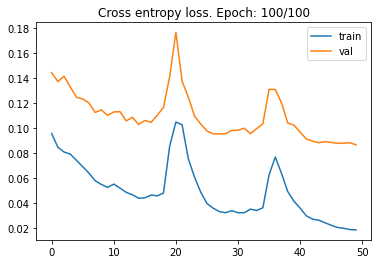

In [218]:
n_epochs = 100
run(n_epochs, t_model, train_dataloader, valid_dataloader, device, opt)

In [219]:
score = test_score(t_model, test_dataloader, device)
print(f'Test F1 score: {score:.4f}')

Test F1 score: 0.9798


### Student GAT model

Let us compare the teacher and srudent model size

Teacher

In [220]:
n_params = sum(p.numel() for p in t_model.parameters() if p.requires_grad)
print(f'Number of parameters: {n_params * 1e-6:.2f}M')

Number of parameters: 2.59M


Student

In [221]:
s_model = GAT(n_layers=5, n_heads=[2, 2, 2, 2, 2], in_dim=num_feats, h_dim=68, out_dim=num_classes)
n_params = sum(p.numel() for p in s_model.parameters() if p.requires_grad)
print(f'Number of parameters: {n_params * 1e-6:.2f}M')

Number of parameters: 0.13M


### Train student without LSP

Here is the regular training of the student model

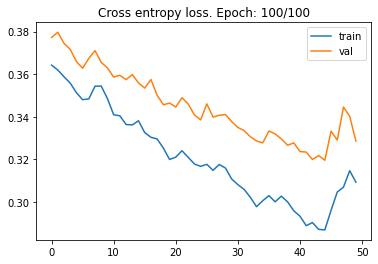

In [222]:
n_runs = 5
scores = []
for i in range(n_runs):
    s_model = GAT(n_layers=5, n_heads=[2, 2, 2, 2, 2], in_dim=num_feats, h_dim=68, out_dim=num_classes)
    s_model.to(device)
    opt = Adam(s_model.parameters(), lr=0.005)
    n_epochs = 100
    run(n_epochs, s_model, train_dataloader, valid_dataloader, device, opt)
    scores.append(test_score(s_model, test_dataloader, device))
scores = np.array(scores)

In [223]:
print(f'Test F1 score: {scores.mean():.4f} ± {2*scores.std():.4f}')

Test F1 score: 0.7869 ± 0.0301


### Graph local structure

In [224]:
s_model = GAT(n_layers=5, n_heads=[2, 2, 2, 2, 2], in_dim=num_feats, h_dim=68, out_dim=num_classes)
s_model.to(device);

In [225]:
graph, feat, label = train_dataset[1]
graph, feat, label = graph.to(device), feat.to(device), label.to(device)

with torch.no_grad():
    _, t_mid_h = t_model(graph, feat)
    logits, s_mid_h = s_model(graph, feat)

In [226]:
len(t_mid_h), len(s_mid_h)

(2, 4)

Let us preserve local structure in the first layer

In [227]:
t_emb = t_mid_h[0]
s_emb = s_mid_h[0]
t_emb.shape, s_emb.shape

(torch.Size([1377, 1024]), torch.Size([1377, 136]))

Local structire describes the distribution of distances between neighbors

$$L S_{i j}=\frac{e^{\text{sim}(z_{i}, z_{j})}}{\sum_{j:(i, j) \in \mathcal{E}} e^{\text{sim}(z_{i}, z_{j})}}$$

Here we apply Gaussian kernel function as a distance function

$$\text{sim}(z_i, z_j) = e^{-\frac{1}{2 \sigma^2}(z_i - z_j)^2}$$

In [228]:
def loc_structure(_graph, emb, sigma=1):
    graph = _graph.remove_self_loop()
    graph.ndata['h'] = emb
    graph.apply_edges(fn.u_sub_v('h', 'h', 'diff'))
    diff = graph.edata['diff']
    h = torch.exp(-(diff**2).sum(1) / 2 / sigma**2)
    return edge_softmax(graph, h)

In [229]:
s_ls = loc_structure(graph, s_emb, sigma=3)
t_ls = loc_structure(graph, t_emb, sigma=3)
t_ls

tensor([0.0400, 0.0054, 0.1250,  ..., 0.0233, 0.0143, 0.0116], device='cuda:0')

In [230]:
def plot_node_ls(v, t_ls, s_ls, _graph):
    graph = _graph.remove_self_loop()
    t_proba = t_ls[graph.in_edges(v, form='eid')].cpu()
    s_proba = s_ls[graph.in_edges(v, form='eid')].cpu()
    x_space = np.arange(t_proba.shape[0])
    w = np.min(np.diff(x_space)) / 3
    plt.bar(x_space, t_proba, w, label='Teacher distribution')
    plt.bar(x_space+w, s_proba, w, label='Student distribution')
    plt.legend(loc='lower left')
    plt.title(f'Local structure of the node {v}')
    plt.show()

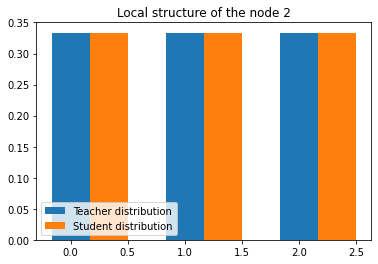

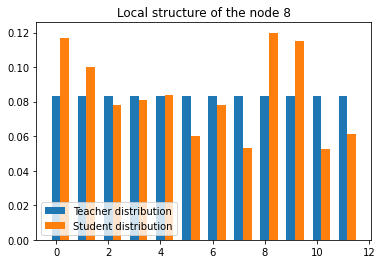

In [231]:
plot_node_ls(2, t_ls, s_ls, graph)
plot_node_ls(8, t_ls, s_ls, graph)

### Graph KL divergence

We will minimize the KL divergence between distributions of teacher local structure and student local structure

$$\mathcal{S}_{i}=D_{K L}\left(L S_{i}^{s}|| L S_{i}^{t}\right)=\sum_{j:(j, i) \in \mathcal{E}} L S_{i j}^{s} \log \left(\frac{L S_{i j}^{s}}{L S_{i j}^{t}}\right)$$

$$\mathcal{L}_\text{LSP}=\frac{1}{N} \sum_{i=1}^{N} \mathcal{S}_{i}$$

We can compute graph KL by message passing framework

<img src='https://raw.githubusercontent.com/netspractice/advanced_gnn/main/lab_knowledge_distillation/message_passing.jpeg' width=500>

In [232]:
def graph_kl(_graph, edgex, edgey):
    graph = _graph.remove_self_loop()
    graph.edata['diff'] = edgex * (torch.log(edgex) - torch.log(edgey))
    graph.update_all(fn.copy_e('diff', 'm'), fn.sum('m', 'kl'))
    return graph.ndata['kl'].mean()

In [233]:
graph_kl(graph, s_ls, t_ls)

tensor(0.0143, device='cuda:0')

In [234]:
graph_kl(graph, t_ls, t_ls)

tensor(0., device='cuda:0')

### LSP loss

We train the student using local structure from the teacher. So, full loss contains cross entropy loss and LSP loss.

$$\mathcal{L}=\mathcal{H}\left(p_{s}, y\right)+\lambda \mathcal{L}_\text{LSP}$$

In [235]:
ce_loss = F.binary_cross_entropy_with_logits(logits, label)
print(f'CE loss: {ce_loss:.4f}')

CE loss: 1.0069


In [236]:
lsp_weight = 100
ce_loss = F.binary_cross_entropy_with_logits(logits, label)
s_ls = loc_structure(graph, s_emb, sigma=1)
t_ls = loc_structure(graph, t_emb, sigma=1)
lsp_loss = graph_kl(graph, s_ls, t_ls)
full_loss = ce_loss + lsp_weight*lsp_loss
print(f'Full loss: {full_loss:.4f}')

Full loss: 1.0928


### Train student with LSP

In [237]:
def lsp_train(t_model, s_model, dataloader, device, opt):
    s_model.train()
    _full_train_loss = []
    _ce_train_loss = []
    for graph, feat, label in dataloader:
        graph, feat, label = graph.to(device), feat.to(device), label.to(device)
        with torch.no_grad():
            _, t_mid_h = t_model(graph, feat)
        logits, s_mid_h = s_model(graph, feat)
        
        ce_loss = F.binary_cross_entropy_with_logits(logits, label)

        lsp_loss = 0
        for target_layer in [-2, -1]:
            s_ls = loc_structure(graph, t_mid_h[target_layer], sigma=1)
            t_ls = loc_structure(graph, s_mid_h[target_layer], sigma=1)
            lsp_loss += graph_kl(graph, s_ls, t_ls)
        
        lsp_weight = 100
        loss = ce_loss + lsp_weight*lsp_loss

        opt.zero_grad()
        loss.backward()
        opt.step()
        _full_train_loss.append(loss.item())
        _ce_train_loss.append(ce_loss.item())
    return sum(_full_train_loss) / len(_full_train_loss), sum(_ce_train_loss) / len(_ce_train_loss)

def lsp_run(n_epochs, t_model, s_model, train_dataloader, valid_dataloader, device, opt):
    full_train_loss, ce_train_loss, val_loss = [], [], []
    for epoch in range(n_epochs):
        
        full, ce = lsp_train(t_model, s_model, train_dataloader, device, opt)
        ce_train_loss.append(ce)
        full_train_loss.append(full)
        
        loss = eval(s_model, valid_dataloader, device)
        val_loss.append(loss)

        plt.plot(
            full_train_loss[-50:], 
            label='Full loss, train', 
            color='tab:blue')
        plt.plot(
            ce_train_loss[-50:], 
            label='CE loss, train', 
            color='tab:blue', 
            linestyle='--')
        plt.plot(val_loss[-50:], label='CE loss, val', color='tab:orange')
        plt.legend()
        plt.title('Loss. Epoch: {}/{}'.format(epoch+1, n_epochs))
        plt.show()
        clear_output(wait=True)

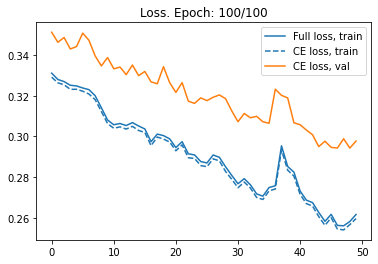

In [238]:
n_runs = 5
scores = []
for i in range(n_runs):
    s_model = GAT(n_layers=5, n_heads=[2, 2, 2, 2, 2], in_dim=num_feats, h_dim=68, out_dim=num_classes)
    s_model.to(device)
    opt = Adam(s_model.parameters(), lr=0.005)
    n_epochs = 100
    lsp_run(n_epochs, t_model, s_model, train_dataloader, valid_dataloader, device, opt)
    scores.append(test_score(s_model, test_dataloader, device))
scores = np.array(scores)

In [239]:
print(f'Test F1 score: {scores.mean():.4f} ± {2*scores.std():.4f}')

Test F1 score: 0.7953 ± 0.0063
